In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from transformer import TimeSeriesTransformer
from inference import inference
from trainer import train_model
from dataset import CustomDataset, BatchSampler
from psd import get_average_spectrum, hellinger_distance

### Lorenz-63

In [12]:
input_dim = 3
d_model = 16
nhead = 16
num_encoder_layers = 3
num_decoder_layers = 3
dim_feedforward = 64
dropout = 0.1
output_dim = 3
input_length = 200
output_length = 10
batch_size = 512
num_epochs = 5000

In [4]:
train_data = np.load('./data/lorenz63_on0.05_train.npy')
dataset = CustomDataset(train_data, input_length=input_length, output_length=output_length)
data_loader = BatchSampler(dataset, batch_size)

In [5]:
for i in range(20):
    model = TimeSeriesTransformer(input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, output_dim)
    loss = train_model(model, data_loader, num_epochs, d_model)
    os.rename('./loss_log.txt', f'./repeat/lorenz63/loss_{i}.txt')
    os.rename('./model.pth', f'./repeat/lorenz63/model_{i}.pth')

Epochs: 100%|██████████| 5000/5000 [08:05<00:00, 10.31it/s, Loss=0.002880]


In [13]:
test_data = np.load('./data/lorenz63_test.npy')
output_steps = 500
dataset = CustomDataset(test_data, input_length=input_length, output_length=output_steps)
data_loader = BatchSampler(dataset, 1000)
x, y = data_loader()

pred63 = {}
ps63 = {}
for i in range(20):
    model = TimeSeriesTransformer(input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, output_dim)
    model.load_state_dict(torch.load(f'./repeat/lorenz63/model_{i}.pth', weights_only=True))
    pred = inference(model, x, input_length=input_length, output_length=output_length, output_steps=output_steps)

    true_data = y[:, 1:, :].numpy()
    pred_data = pred[:, input_length:, :]
    pred63[i] = pred_data
    sigma = 10
    ps63[i] = np.array([get_average_spectrum(pred_data[:, :, dim], sigma) for dim in range(3)])

100%|██████████| 500/500 [00:15<00:00, 31.37it/s]


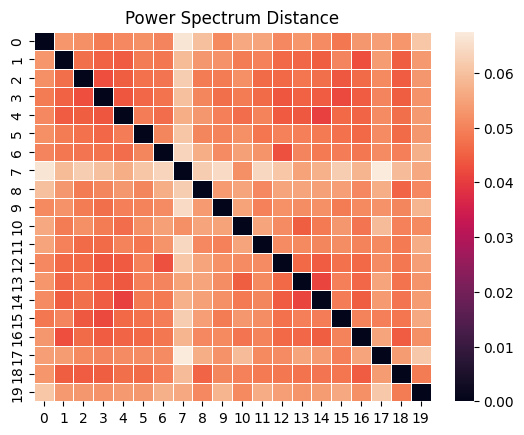

0.05091874421367636 0.005040558094504187


In [51]:
pse = np.array([[np.mean([hellinger_distance(ps63[i][dim], ps63[j][dim]) for dim in range(3)])
                 for i in range(20)] for j in range(20)])
sns.heatmap(pse, linewidth=0.5)
plt.title('Power Spectrum Distance')
plt.show()
print(np.array([pse[i, j] for i in range(20) for j in range(20) if i > j]).mean(),
      np.array([pse[i, j] for i in range(20) for j in range(20) if i > j]).std())

### Lorenz-96

In [42]:
input_dim = 20
d_model = 256
nhead = 8
num_encoder_layers = 8
num_decoder_layers = 8
dim_feedforward = 1024
dropout = 0.1
output_dim = 20
input_length = 80
output_length = 10
batch_size = 512
num_epochs = 5000

In [7]:
train_data = np.load('./data/lorenz96_on0.05_train.npy')
dataset = CustomDataset(train_data, input_length=input_length, output_length=output_length)
data_loader = BatchSampler(dataset, batch_size)

In [8]:
for i in range(20):
    model = TimeSeriesTransformer(input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, output_dim)
    loss = train_model(model, data_loader, num_epochs, d_model)
    os.rename('./loss_log.txt', f'./repeat/lorenz96/loss_{i}.txt')
    os.rename('./model.pth', f'./repeat/lorenz96/model_{i}.pth')

Epochs: 100%|██████████| 5000/5000 [19:27<00:00,  4.28it/s, Loss=0.211936]


In [10]:
for i in [16, 19]:
    model = TimeSeriesTransformer(input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, output_dim)
    loss = train_model(model, data_loader, num_epochs, d_model)
    os.rename('./loss_log.txt', f'./repeat/lorenz96/loss_{i}.txt')
    os.rename('./model.pth', f'./repeat/lorenz96/model_{i}.pth')

Epochs: 100%|██████████| 5000/5000 [21:44<00:00,  3.83it/s, Loss=0.004737]


In [43]:
test_data = np.load('./data/lorenz96_test.npy')
output_steps = 500
dataset = CustomDataset(test_data, input_length=input_length, output_length=output_steps)
data_loader = BatchSampler(dataset, 1000)
x, y = data_loader()

pred96 = {}
ps96 = {}
for i in range(20):
    model = TimeSeriesTransformer(input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, output_dim)
    model.load_state_dict(torch.load(f'./repeat/lorenz96/model_{i}.pth', weights_only=True))
    pred = inference(model, x, input_length=input_length, output_length=output_length, output_steps=output_steps)

    true_data = y[:, 1:, :].numpy()
    pred_data = pred[:, input_length:, :]
    pred96[i] = pred_data
    sigma = 10
    ps96[i] = np.array([get_average_spectrum(pred_data[:, :, dim], sigma) for dim in range(3)])

100%|██████████| 500/500 [00:58<00:00,  8.49it/s]


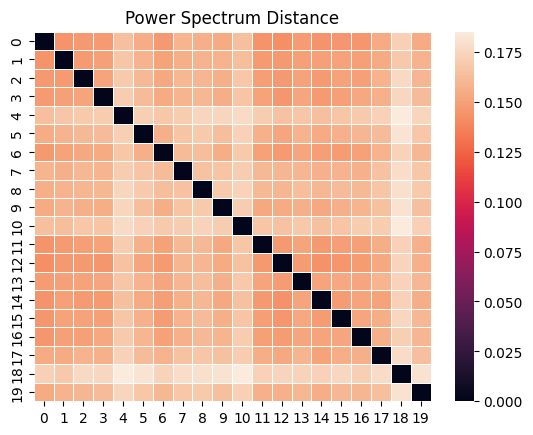

0.15974176232303255 0.0095818476659887


In [50]:
pse = np.array([[np.mean([hellinger_distance(ps96[i][dim], ps96[j][dim]) for dim in range(3)])
                 for i in range(20)] for j in range(20)])
sns.heatmap(pse, linewidth=0.5)
plt.title('Power Spectrum Distance')
plt.show()
print(np.array([pse[i, j] for i in range(20) for j in range(20) if i > j]).mean(),
      np.array([pse[i, j] for i in range(20) for j in range(20) if i > j]).std())